# Ερώτηση 3 (Clustering)

## Loading data

In [164]:
import pandas as pd
import numpy as np
import json
import time 

yelp_dataset_path = '../yelp-dataset/'
buisness_v_path = yelp_dataset_path + 'yelp_academic_dataset_business.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_business.json'

dataset_business = []
categories_order = ["Beauty & Spas", "Shopping", "Bars"]

start = time.time()

with open(buisness_v_path, 'r', encoding="utf8") as buisness_file:
    for line in buisness_file:
        json_dict = json.loads(line)
        if  json_dict['city'] == 'Toronto' and \
            json_dict['review_count'] > 10 and \
            json_dict['categories'] is not None and \
            any(word in json_dict['categories'] for word in categories_order):
                temp_cat = [cat for cat in categories_order if cat in json_dict['categories']][0]
                dataset_business.append([json_dict['business_id'], temp_cat])
                

stop = time.time()
print("Read file in {} seconds".format(stop-start))

Read file in 2.1462855339050293 seconds


In [165]:
np_business = np.array(dataset_business)
np_business_id = np_business[:,0]

In [166]:
def get_index(business_id):
    index = np.where(np_business_id == business_id)[0]
    return index

In [167]:
start = time.time()
business_review_txt = [[] for i in range(int(len(np_business)))]
review_v_path = yelp_dataset_path + 'yelp_academic_dataset_review.json'
leftK_path = '/home/left/Desktop/dataMining/set2/ask2/yelp_academic_dataset_review.json'

with open(review_v_path, 'r', encoding="utf8") as reviews_file:
    for line in reviews_file:
        json_dict = json.loads(line)
        index = get_index(json_dict['business_id'])

        if index.size > 0:
            if len(business_review_txt[index[0]]) == 0:
                business_review_txt[index[0]] = json_dict['text']
            else:
                business_review_txt[index[0]] += json_dict['text']

stop = time.time()

print("Read file in {} mins".format((stop-start)/60))

Read file in 4.798638542493184 mins


## TF-IDF

In [205]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()
fitted_vectorizer = tfidf.fit_transform(business_review_txt)

## Kmeans

In [206]:
from sklearn.cluster import KMeans
import sklearn.cluster as sk_cluster
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

kmeans = sk_cluster.KMeans(n_clusters=3)
kmeans.fit_predict(fitted_vectorizer)
y_pred = kmeans.labels_
centroids = kmeans.cluster_centers_
error = kmeans.inertia_

Total error: 1232.5649117398648
Cluster Centroids: 
[[2.18981104e-03 2.44069256e-04 3.15658292e-06 ... 3.25364281e-05
  0.00000000e+00 0.00000000e+00]
 [2.19632956e-03 7.87415212e-04 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [2.10853516e-03 1.25674479e-05 0.00000000e+00 ... 0.00000000e+00
  1.04011942e-04 1.04011942e-04]]


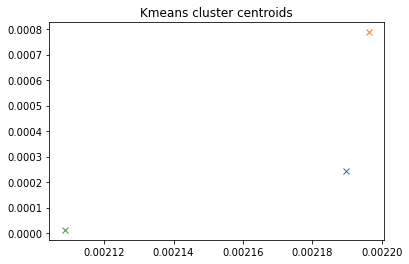

In [207]:
# General information
print("Total error: {}".format(error))
print("Cluster Centroids: \n{}".format(centroids))

for centroids in kmeans.cluster_centers_:
    plt.plot(centroids[0], centroids[1], marker='x')
plt.title('Kmeans cluster centroids')
plt.show()

0: 1705, 1: 757, 2: 803, sum: 3265
Confusion matrix : 
[[1330   83  292]
 [   9  748    0]
 [  63  738    2]]


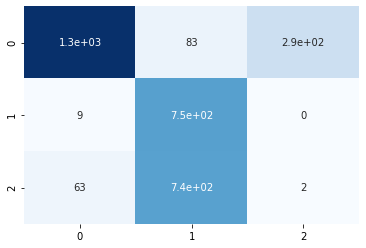

Precision : [0.94864479 0.47673678 0.00680272]
Recall : [0.78005865 0.98811096 0.00249066]


In [208]:
# True values table: Μatching categories to numbers
true_labels = np_business[:,1]
for i in range(len(true_labels)):
    if true_labels[i]=='Bars':
        true_labels[i]=0
    if true_labels[i]=='Beauty & Spas':
        true_labels[i]=1
    if true_labels[i]=='Shopping':
        true_labels[i]=2
    
true_labels = [int(i) for i in true_labels] 
n0 = true_labels.count(0)
n1 = true_labels.count(1)
n2 = true_labels.count(2)
print('0: {}, 1: {}, 2: {}, sum: {}'.format(n0, n1, n2, n0+n1+n2))

# Confusion matrix
cf_matrix = confusion_matrix(true_labels, y_pred)

print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


[0, 1, 0]
Confusion matrix : 
[[1622   83    0]
 [   9  748    0]
 [  65  738    0]]


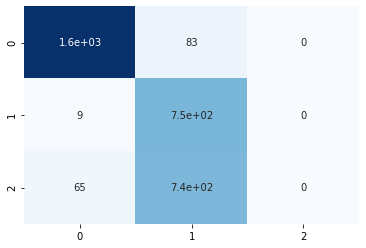

Precision : [0.94864479 0.47673678 0.00680272]
Recall : [0.78005865 0.98811096 0.00249066]


In [209]:
# x_axis_labels = ['Bars', 'Beauty & Spas', 'Shopping'] 
# y_axis_labels = [0, 1, 2] 
# ,
#                         xticklabels=x_axis_labels, 
#                         yticklabels=y_axis_labels

mapping = list(np.argmax(cf_matrix, axis=0))
print(mapping)

mapped_kmeans_labels = [0 for i in range(len(y_pred))]
for i in range(len(y_pred)):
    mapped_kmeans_labels[i] = mapping[y_pred[i]]

cf_matrix = confusion_matrix(true_labels, mapped_kmeans_labels)
print("Confusion matrix : \n{}".format(cf_matrix))
sns.heatmap(cf_matrix,  annot=True, 
                        cmap='Blues',
                        cbar=False)
plt.show()

# Precision - Recall
precision = metrics.precision_score(true_labels, y_pred, average=None)
recall = metrics.recall_score(true_labels, y_pred, average = None)

print("Precision : {}".format(precision))
print("Recall : {}".format(recall))


Clusters 2, score 0.076
Clusters 3, score 0.029
Clusters 4, score 0.043
Clusters 5, score 0.043


Text(0, 0.5, 'Error')

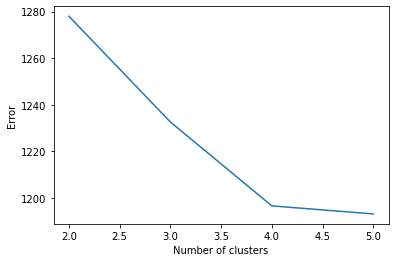

In [210]:
from sklearn.metrics import silhouette_score

n_clusters = 5
error = np.zeros(n_clusters+1)
error[0] = 0
max_score = 0
f_clasters = 0
#sc = np.zeros(n_clusters+1)
for k in range(2,n_clusters+1):
    kmeans = sk_cluster.KMeans(n_clusters=k, init='k-means++')
    preds = kmeans.fit_predict(fitted_vectorizer)
    error[k] = kmeans.inertia_
    score = silhouette_score(fitted_vectorizer, preds)
    print('Clusters {}, score {:.3f}'.format(k, score))
    if (score > max_score):
        f_clasters = k 
        max_score = score

plt.plot(range(2,len(error)),error[2:])
plt.xlabel('Number of clusters')
plt.ylabel('Error')

In [211]:
# from sklearn.metrics import silhouette_samples, silhouette_score

# for n_clusters in range(2, 11):
#     kmeans = KMeans(n_clusters=n_clusters)
#     cluster_labels = kmeans.fit_predict(fitted_vectorizer)

#     silhouette_avg = silhouette_score(fitted_vectorizer, cluster_labels)
#     print("For n_clusters =", n_clusters,
#             "The average silhouette_score is :", silhouette_avg)

In [212]:
# data_for_agglo = fitted_vectorizer.todense()

# from sklearn.cluster import AgglomerativeClustering
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='ward')
# predictions = agglomerative.fit_predict(data_for_agglo)


# # MAKE CONF MATRIX HERE FOR 'WARD' PREC/REC ETC.

In [213]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='complete')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR ;COMPLETE' PREC/REC ETC.

In [214]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='average')
# predictions = agglomerative.fit_predict(data_for_agglo)

# MAKE CONF MATRIX HERE FOR 'AVERAGE' PREC/REC ETC.

In [215]:
# agglomerative = sk_cluster.AgglomerativeClustering(n_clusters=3, linkage='single')
# predictions = agglomerative.fit_predict(data_for_agglo)

# # MAKE CONF MATRIX HERE FOR 'SINGLE' PREC/REC ETC.

In [216]:
# print(predictions)